### 이진화
어떠한 기준 T로 명암값을 흑과 백 하나로 결정하는 방법이다. 이때 기준 T를 임계값(Threshold)라고 한다.
일반적인 식은 다음과 같다.

$$
b(j,i) = \begin{cases}1, f(j,i) \ge T \\ 0, f(j,i) < T \end{cases}
$$

이번에는 레나사진에서 히스토그램을 추출하고 여기서 값을 정해 이진화를 진행할 것이다.

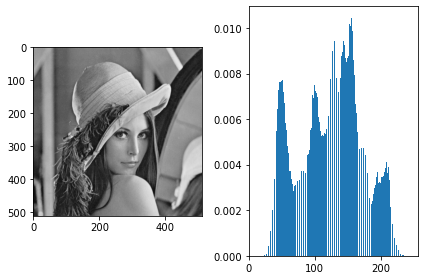

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('./data/lena.jpg',cv2.IMREAD_GRAYSCALE)

hist = np.zeros(256)
img_flat = np.reshape(img,-1)
for i in range(len(img_flat)):
    hist[img_flat[i]]+=1
hist = hist/len(img_flat)

fig = plt.figure()
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.subplot(122)
plt.bar(np.arange(256),hist)
plt.xlim([0,256])
fig.tight_layout()
plt.show()

분포가 최대한 고른 지점은 약 120정도로 보인다. 120을 임계값으로 이진화를 진행한다.

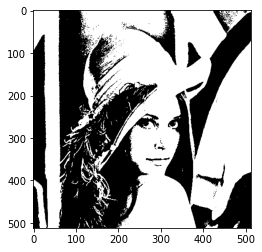

In [2]:
def Threshold(img, T):
    return np.uint8(img>T)*255

bi_img = Threshold(img,120)

plt.imshow(bi_img,cmap='gray')
plt.show()

임계값 방법은 단순한 반면 이렇게 히스토그램을 관찰하여 해야하지만 컴퓨터 비전에서는 이것을 자동화 해야한다. 히스토그램의 봉우리 부분이 뚜렸하지 않을 수록 임계값을 콕 집어내기 애매한 경우가 많다.

### 오츄알고리즘 (Otsu Algoritm)
오츄가 제안한 알고리즘은 현재도 널리 사용되는 이진화 알고리즘이다. 임계값 t를 기준으로 화소를 두 집합으로 나누었을 때, 각 집합의 명암 분포가 균일할수록 좋다는 점에 착안해 균일성이 클수록 t에게 높은 점수를 준다. 균일성은 그룹의 분산으로 측정하고 분산이 작을수록 균일성이 높다. 가능한 t에 대해 점수를 계산한 후 가장 좋은 t를 최종 임계값으로 취한다. 일종의 최적화 알고리즘이다.
여기서 목적 함수(Objective function) 혹은 비용 함수(Cost function)은 분산을 사용한다. 분산이 작을수록 균일성이 크므로 목적 함수값이 작을수록 점수가 높다고 거꾸로 생각해야 한다.

식은 다음과같다.
$$
T = \underset{t \in \left\{ 0,1,...,L-1 \right\}}{argmin} v_{within}(t)
$$

$$
v_{within}(t) = w_{0}(t)v_{0}(t) + w_{1}(t)v_{1}(t)
$$

$$
w_{0}(t) = \sum_{i=0}^{t} \hat{h}(i), \qquad w_{1}(t) = \sum_{i=t+1}^{L-1} \hat{h}(i)
$$

$$
\mu_{0}(t) = \frac{1}{w_{0}(t)} \sum_{i=0}^{t} i \hat{h}(i), \qquad \mu_{1}(t) = \frac{1}{w_{1}(t)} \sum_{i=t+1}^{L-1} i \hat{h}(i)
$$

$$
v_{0}(t) = \frac{1}{w_{0}(t)} \sum_{i=0}^{t} \hat{h}(i)(i-\mu_{0}(t))^{2}, \qquad v_{1}(t) = \frac{1}{w_{1}(t)} \sum_{i=t+1}^{L-1} \hat{h}(i)(i-\mu_{1}(t))^{2}
$$

여기서 v_within(t) 가 목적 함수 역할을 하고 두 분산의 가중치 합으로 정의된다. w0(t)와 w1(t)는 임계값 t에 따라 생성된 흑 화소와 백 화소 집합의 크기로서 가중치 역할을 한다. v0(t)와 v1(t)는 두 집합의 분산이다. mu는 평균값이다.

여기서 두 개의 가중치와 두 개의 분산을 L번 계산해야 하므로 알고리즘의 점근적 시간 복잡도(asymptotic time complexity)는 O(L^2)이다. 따라서 실시간 처리에서는 부담스럽다.
개선하기 위해 먼저 mu와 v는 주어진 영상에 대해 한 번만 계산하면 되기 떄문에 상수로 간주 가능하다.

$$
\mu = \sum_{i=0}^{L-1}i\hat{h}(i), \ v=\sum_{i=0}^{L-1}(i-\mu)^2\hat{h}(i)
$$

이 식은 다음과 같이 쓸 수 있다.

$$
v = \sum_{i=0}^{t}(i-\mu_{0}(t)+\mu_{0}(t)-\mu)^2\hat{h}(i) + \sum_{i=t+1}^{L-1}(i-\mu_{1}(t)+\mu_{1}(t)-\mu)^2\hat{h}(i)
$$

$$
= \sum_{i=0}^{t}((i-\mu_{0}(t))^2 + 2(i-\mu_{0}(t))(\mu_{0}(t)-\mu)+(\mu_{0}(t)-\mu)^2)\hat{h}(i)+
$$

$$
\sum_{i=t+1}^{L-1}((i-\mu_{1}(t))^2+2(i-\mu_{1}(t))(\mu_{1}(t)-\mu)+(\mu_{1}(t)-\mu)^2)\hat{h}(i)
$$

$$
= \sum_{i=0}^{t}((i-\mu_{0}(t))^2 + (\mu_{0}(t)-\mu)^2)\hat{h}(i) + \sum_{i=t+1}^{L-1}((i-\mu_{1}(t))^2+(\mu_{1}(t)-\mu)^2)\hat{h}(i)
$$

이전 식에 다시 대입하면

$$
v=\left\{ w_{0}(t)(\mu_{0}(t)-\mu)^2 + w_{1}(t)(\mu_{1}(t)-\mu)^2\right\} + \sum_{i=0}^{t}(i-\mu_{0}(t))^2\hat{h}(i)+\sum_{i=t+1}^{L-1}(i-\mu_{1}(t))^2\hat{h}(i)
$$

$$
= \left\{ w_{0}(t)(\mu_{0}(t)-\mu)^2 + w_{1}(t)(\mu_{1}(t)-\mu)^2\right\} + \left\{ w_{0}(t)v_{0}(t)+w_{1}(t)v_{1}(t)\right\}
$$

$$w_{1}(t) = 1- w_{0}(t)$$와 $$\mu = w_{0}(t) \mu_{0}(t) + w_{1}(t) \mu_{1}(t)$$

를 대입해 정리하면 (사실 이 부분 이해가 안간다)

$$
v = w_{0}(t)(1-w_{0}(t))(\mu_{0}(t)-\mu_{1}(t))^2 + v_{within}(t) = v_{between}(t)+v_{within}(t)
$$

v는 상수 이므로 v-within(t)를 최소화하는 일은 v-between(t)를 최대화하는 것과 똑같다. 따라서 최대화 문제를 다음과 같이 바꿀 수 있다.

$$
T = \underset{t \in \left\{ 0,1,...,L-1 \right\}}{argmin} v_{between}(t)
$$

$$
where, v_{between}(t) = w_{0}(t)(1-w_{0}(t))(\mu_{0}(t)-\mu_{1}(t))^2
$$

전체적인 수식은 다음과 같이 쓸 수 있다.

$$
초깃값 (t=0) : w_{0}(0)=\hat{h}(0), \mu_{0}(0)=0
$$

$$
순환식(t>0) : w_{0}(t)=w_{0}(t-1)+\hat{h}(t)
$$

$$
\mu_{0}(t) = \frac{w_{0}(t-1)\mu_{0}(t-1)+t\hat{h}(t)}{w_{0}(t)}
$$

$$
\mu_{1}(t) = \frac{\mu - w_{0}(t)\mu_{0}(t)}{1-w_{0}(t)}
$$


가장 먼저 mu를 구하고 나머지 값들을 초기화 해준다.

In [3]:
mu = 0

for i in range(256):
    mu+= i*hist[i]
    
w =np.zeros(256)
mu0 =np.zeros(256)
mu1 =np.zeros(256)
T_bet =0
w[0] = hist[0]
threshold=0

순환식을 따라 T_bet 값이 최대값일때마다 threshold 값을 index값으로 변경한다.

In [4]:
for i in range(1,256):
    w[i] = w[i-1]+hist[i]
    mu0[i] = (w[i-1]*mu0[i-1]+i*hist[i])/(w[i]+1e-10)
    mu1[i] = (mu - w[i]*mu0[i])/(1-w[i]+1e-10)
    n_t = w[i]*(1-w[i])*((mu0[i]-mu1[i])**2)

    if n_t>T_bet:
        T_bet = n_t
        threshold = i


이제 이 threshold 값으로 이진화를 진행하면 끝이다.

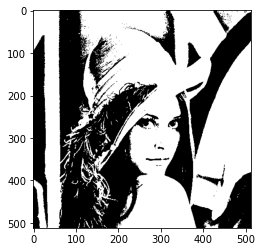

In [5]:
otsu_img = Threshold(img,threshold)

plt.imshow(otsu_img,cmap='gray')
plt.show()

opencv에서는 cv2.threshold 함수를 사용하면 가능하다. 각 flag마다 method가 살짝씩 다르게 작동한다.
otsu는 따로 작용하는게 아니라 thr6과 같이 입력해야 한다.

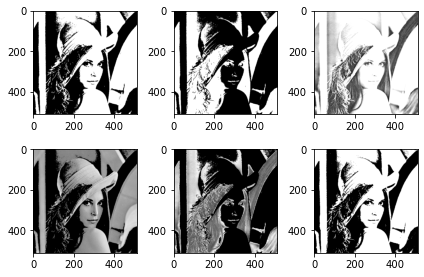

In [6]:
ret, thr = cv2.threshold(img,120,255,cv2.THRESH_BINARY)
ret2, thr2 = cv2.threshold(img,120,255,cv2.THRESH_BINARY_INV)
ret3, thr3 = cv2.threshold(img,120,255,cv2.THRESH_TRUNC) # 픽셀값이 임계값 보다 크면 임계값, 작으면 픽셀값 그대로
ret4, thr4 = cv2.threshold(img,120,255,cv2.THRESH_TOZERO) # 픽셀값이 임계값 보다 크면 픽셀 값 그대로, 작으면 0
ret5, thr5 = cv2.threshold(img,120,255,cv2.THRESH_TOZERO_INV) # 픽셀값이 임계값 보다 크면 0, 작으면 픽셀값 그대로
ret6, thr6 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

fig = plt.figure()
plt.subplot(231)
plt.imshow(thr,cmap='gray')
plt.subplot(232)
plt.imshow(thr2,cmap='gray')
plt.subplot(233)
plt.imshow(thr3,cmap='gray')
plt.subplot(234)
plt.imshow(thr4,cmap='gray')
plt.subplot(235)
plt.imshow(thr5,cmap='gray')
plt.subplot(236)
plt.imshow(thr6,cmap='gray')
fig.tight_layout()
plt.show()